In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/health-care')

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

from tensorflow import keras
import tensorflow as tf
import numpy as np

import random
from collections import defaultdict

from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical

SEED = 765

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

train_features=pd.read_csv('train_features.csv')
train_labels =pd.read_csv('train_labels.csv')

test=pd.read_csv('test_features.csv')
submission=pd.read_csv('sample_submission.csv')

In [ ]:
train_labels['label_desc'].value_counts()[:]

Non-Exercise                                    1518
Device on Table                                   97
Plank                                             55
Wall Squat                                        48
Jump Rope                                         47
                                                ... 
Triceps Kickback (knee on bench) (right arm)      13
Triceps Kickback (knee on bench) (left arm)       12
Arm Band Adjustment                               12
Dumbbell Row (knee on bench) (right arm)          12
Dumbbell Row (knee on bench) (left arm)           12
Name: label_desc, Length: 61, dtype: int64

In [ ]:
train_mean = train_features.mean()
train_std = train_features.std()

train_min = train_features.min()
train_max = train_features.max()

after_train = (train_features - train_mean) / train_std 
# after_train = (train_features - train_min) / (train_max - train_min)

test = (test - train_mean) / train_std 
# test = (test - train_min) / (train_max - train_min)

In [ ]:
y = train_labels['label']

In [ ]:
X=np.array(tf.reshape(np.array(after_train.iloc[:,2:]),[-1, 600, 6]))
# y = tf.keras.utils.to_categorical(train_labels['label']) 
y = train_labels['label'].to_numpy()

In [ ]:
data_dict = defaultdict(list)

for i, tag in enumerate(train_labels['label']):
    data_dict[tag].append(np.array(X[i]))

In [ ]:
data_key = set(data_dict.keys())
data_key.remove(26)
data_size = len(data_dict[26])

In [ ]:
augmentation_dict = defaultdict(list)
augmentation_dict[26] = data_dict[26]

for key in data_key:
    # print(key, end=': ')
    augmentation_dict[key] = data_dict[key].copy()

    while len(augmentation_dict[key]) != 97 * 2:
        target_idx = random.randrange(0,len(data_dict[key]))
        shift = int(random.random()*600)

        data = data_dict[key][target_idx]

        shift_data = np.roll(data, shift, axis=0)

        augmentation_dict[key].append(shift_data)
    
    # print(len(augmentation_dict[key]))



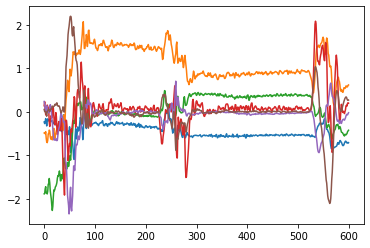

In [ ]:
plt.plot(data)

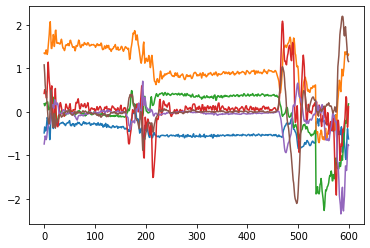

In [ ]:
plt.plot(shift_data)

In [ ]:
new_x = []
new_y = []

for key in augmentation_dict.keys():
    new_x += augmentation_dict[key]
    new_y += [key for _ in range(len(augmentation_dict[key]))]

X = np.array(new_x)
# y = tf.keras.utils.to_categorical(new_y)
y = np.array(new_y)

In [ ]:
# def build_model():
#     model = keras.models.Sequential([
#         keras.layers.Conv1D(128,  30, padding="same", activation="relu", input_shape=(600,6)),
#         keras.layers.Dropout(.3),
#         keras.layers.Conv1D(128,  30, padding="same", activation="relu"),
#         keras.layers.GlobalAveragePooling1D(),
#         keras.layers.Dense(64, activation='relu'),
#         keras.layers.Dropout(.3),
#         keras.layers.Dense(61, activation='softmax'),
#     ])

#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

def build_model():
    model = keras.models.Sequential([
        keras.layers.Conv1D(128,  30, padding="same", activation="relu", input_shape=(600,6)),
        keras.layers.GlobalAveragePooling1D(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(.3),
        keras.layers.Dense(61, activation='softmax'),
    ])

    model.compile(optimizer=keras.optimizers.Adam(.005), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# def build_model():
#     kernel_size = [5, 10, 15, 30, 60, 120]
#     filter = 16

#     def multi_kernel(filter_size, input_layer):
#         conv_blocks = []

#         for ks in kernel_size:
#             conv = keras.layers.Conv1D(filter_size, ks, padding="same", activation="relu", strides=1)(input_layer)
#             pool = keras.layers.AveragePooling1D()(conv)
#             drop = keras.layers.Dropout(.3)(pool)
#             conv = keras.layers.Conv1D(filter_size, ks, padding="same", activation="relu", strides=1)(drop)
#             pool = keras.layers.AveragePooling1D()(conv)
#             drop = keras.layers.Dropout(.3)(pool)
#             conv = keras.layers.Conv1D(filter_size, ks, padding="same", activation="relu", strides=1)(drop)
#             pool = keras.layers.GlobalAveragePooling1D()(conv)

#             conv_blocks.append(pool)
        
#         return keras.layers.Concatenate()(conv_blocks)

#     input_x = keras.layers.Input((600,6))
#     convs = multi_kernel(filter, input_x)
#     do1 = keras.layers.Dropout(.3)(convs)
#     d2 = keras.layers.Dense(128, activation='relu')(do1)
#     output = keras.layers.Dense(61, activation='softmax')(d2)

#     model = keras.models.Model(input_x, output)
#     model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(.005), metrics=['acc'])
#     # model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(.003), metrics=['acc'])

#     return model

In [ ]:
def build_model():
    kernel_size = 30
    filter = 48

    def multi_kernel(filter_size, input_layer):
        conv_blocks = []

        avg = keras.layers.GlobalAveragePooling1D()(input_layer)

        conv = keras.layers.Conv1D(filter, kernel_size, padding="same", activation="relu", strides=1)(input_layer)
        drop = keras.layers.Dropout(.3)(conv)
        conv = keras.layers.Conv1D(filter, kernel_size, padding="same", activation="relu", strides=1)(drop)
        conv = keras.layers.Conv1D(6, 1, padding="same", activation="relu", strides=1)(conv)

        add = keras.layers.Add()([avg, conv])

        att = keras.layers.Attention()([add, input_layer])

        return att

    input_x = keras.layers.Input((600,6))
    convs = multi_kernel(filter, input_x)
    convs = multi_kernel(filter, convs)
    convs = multi_kernel(filter, convs)
    fl = keras.layers.Flatten()(convs)

    # concatenate = keras.layers.Concatenate()(convs)
    concatenate = fl
    do1 = keras.layers.Dropout(.3)(concatenate)
    d1 = keras.layers.Dense(256, activation='relu')(do1)
    do2 = keras.layers.Dropout(.3)(d1)
    d2 = keras.layers.Dense(128, activation='relu')(do2)
    do3 = keras.layers.Dropout(.3)(d2)
    output = keras.layers.Dense(61, activation='softmax')(do3)

    model = keras.models.Model(input_x, output)
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(.003), metrics=['acc'])
    # model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(.003), metrics=['acc'])

    return model

In [ ]:
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, Activation, BatchNormalization, Flatten, Reshape, multiply, add, MaxPooling2D, Dropout, Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.models import Model

def build_model():
    r = 16
    d = 4
    def spatial_attention(in_layer, in_ch, r, d):
        x = Conv1D(in_ch//r, kernel_size=1, padding='same', use_bias=False)(in_layer)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv1D(in_ch//r, kernel_size=3, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv1D(in_ch//r, kernel_size=3, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv1D(1, kernel_size=1, padding='same')(x)
        
        return x

    def channel_attention(in_layer, in_ch, r):
        x = GlobalAveragePooling1D()(in_layer)
        # x = Flatten()(x) ?? 원래 케라스에서는 GlobalAvgPooling 하면 자동으로 1차원으로 줄어든다. 그래서 그 담에 Flatten 안 넣어준 것
        x = Dense(in_ch//r, use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dense(in_ch)(x)
        # x = Reshape((1, 1, in_ch))(x)
        
        return x

    def Bottleneck_Attention_Module(in_layer, in_ch, r, d):
        Mc = channel_attention(in_layer, in_ch, r)
        Ms = spatial_attention(in_layer, in_ch, r, d)
        M = multiply([Ms, Mc])
        M = Activation('sigmoid')(M)
        
        x = multiply([in_layer, M])
        x = add([in_layer, x])
        
        return x

    input_x = Input((600,6))
    x = Conv1D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(input_x)
    x = Bottleneck_Attention_Module(x, 32, r, d)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.5)(x)
    x = Conv1D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = Bottleneck_Attention_Module(x, 32, r, d)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    outputs = keras.layers.Dense(61, activation='softmax')(x)

    model = Model(inputs=input_x, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(.002), metrics=['acc'])

    return model

In [ ]:
model = build_model()
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_69 (Conv1D)           (None, 600, 128)          23168     
_________________________________________________________________
global_average_pooling1d_25  (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_53 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 61)                7869      
Total params: 47,549
Trainable params: 47,549
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=0.20, random_state=765, shuffle=True)

In [ ]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(train_x, to_categorical(train_y), validation_data=(val_x, to_categorical(val_y)), shuffle=True, epochs=20, batch_size=1024, callbacks=[es])

Epoch 1/20
11/11 [==============================] - 1s 74ms/step - loss: 3.7420 - accuracy: 0.1189 - val_loss: 2.5431 - val_accuracy: 0.3210
Epoch 2/20
11/11 [==============================] - 1s 55ms/step - loss: 2.6075 - accuracy: 0.2949 - val_loss: 1.9804 - val_accuracy: 0.4403
Epoch 3/20
11/11 [==============================] - 1s 54ms/step - loss: 2.0669 - accuracy: 0.4009 - val_loss: 1.6597 - val_accuracy: 0.5224
Epoch 4/20
11/11 [==============================] - 1s 66ms/step - loss: 1.7941 - accuracy: 0.4580 - val_loss: 1.4572 - val_accuracy: 0.5919
Epoch 5/20
11/11 [==============================] - 1s 54ms/step - loss: 1.6038 - accuracy: 0.5084 - val_loss: 1.3130 - val_accuracy: 0.6106
Epoch 6/20
11/11 [==============================] - 1s 55ms/step - loss: 1.4481 - accuracy: 0.5605 - val_loss: 1.1608 - val_accuracy: 0.6672
Epoch 7/20
11/11 [==============================] - 1s 54ms/step - loss: 1.3025 - accuracy: 0.5971 - val_loss: 1.0788 - val_accuracy: 0.6831
Epoch 8/20
11

In [ ]:
# from sklearn.model_selection import train_test_split
# train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=0.20, random_state=765, shuffle=True)

n_fold = 5
n_class = 61
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=765)

test_X=tf.reshape(np.array(test.iloc[:,2:]),[-1, 600, 6])

p_val = np.zeros((X.shape[0], n_class))
p_tst = np.zeros((test_X.shape[0], n_class))

for i, (i_trn, i_val) in enumerate(cv.split(X, y), 1):
    print(f'training model for CV #{i}')
    es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, verbose=1, mode='min', baseline=None, restore_best_weights=True)

    clf = build_model()
    clf.fit(X[i_trn], to_categorical(y[i_trn]), validation_data=(X[i_val], to_categorical(y[i_val])), epochs=100, batch_size=512, callbacks=[es])
    
    p_val[i_val, :] = clf.predict(X[i_val])
    p_tst += clf.predict(test_X) / n_fold

training model for CV #1
[<KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'global_average_pooling1d_43')>, <KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'global_average_pooling1d_44')>, <KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'global_average_pooling1d_45')>]
Epoch 1/100
12/12 [==============================] - 3s 96ms/step - loss: 4.0236 - acc: 0.1575 - val_loss: 3.7145 - val_acc: 0.2071
Epoch 2/100
12/12 [==============================] - 0s 35ms/step - loss: 3.6688 - acc: 0.2057 - val_loss: 3.1767 - val_acc: 0.2207
Epoch 3/100
12/12 [==============================] - 0s 35ms/step - loss: 3.1452 - acc: 0.2269 - val_loss: 2.5708 - val_acc: 0.3154
Epoch 4/100
12/12 [==============================] - 0s 35ms/step - loss: 2.6445 - acc: 0.2932 - val_loss: 2.1895 - val_acc: 0.3985
Epoch 5/100
12/12 [==============================] - 0s 35ms/step - loss: 2.2422 - acc: 0.3647 - val_loss: 1.9005 - val_acc: 0.4673
Epoch 6/100
12/12 [=======

In [ ]:
test_X=tf.reshape(np.array(test.iloc[:,2:]),[-1, 600, 6])

In [ ]:
prediction=model.predict(test_X)
submission.iloc[:,1:]=prediction
# submission.iloc[:,1:]=p_tst

In [ ]:
import datetime
cur_time = datetime.datetime.now() + datetime.timedelta(hours=9)
cur_time_str = f'{cur_time:%Y%m%d}-{cur_time:%H-%M}'
model.save(f'{cur_time_str}-model')
submission.to_csv(f'{cur_time_str}-submission.csv', index=False)

INFO:tensorflow:Assets written to: 20210215-00-09-model/assets
